In [25]:
# Usual imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import os
print(os.listdir("../input"))

# Plotly based imports for visualization
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
!python -m spacy download en_core_web_lg



import nltk
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

ModuleNotFoundError: No module named 'pyLDAvis'

In [1]:
import spacy

In [3]:
all_reviews = pd.read_csv("review_df_test.csv") 

In [4]:
all_reviews['text'] = all_reviews['title'] + all_reviews['review_text']
all_reviews = all_reviews[['text', 'skin_tone']]

In [5]:
dark_tones = ['deep', 'dark']
dark_tones = all_reviews.loc[all_reviews['skin_tone'].isin(dark_tones)]
dark_tones = dark_tones['text']
dark_tones['index'] = dark_tones.index

/Users/bridget/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1015: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
/Users/bridget/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
dark_tones

18       Nothing Compares!This foundation is the busine...
27       Liquid GoldI call this stuff Liquid Gold becau...
index                  Int64Index([18, 27], dtype='int64')
Name: text, dtype: object

In [7]:
all_reviews = all_reviews[['text']]
all_reviews['index'] = all_reviews.index
documents = all_reviews

In [8]:
with open("review_data.txt", "r") as text_file:
    data = text_file.read().split('\n')

In [8]:
data

["It really is all that!!!I'd been on the fence about purchasing this for a long time...I am a self-confessed product junkie and I have plenty of foundations I should be using up before buying more. I received a sample of this in 5.5, which is darker than I would ever go. But I still tried it out of curiosity...it wasn't really off the charts too dark and I loved the way it made my skin look. Sooooo...during the 15% off VIB sale I bought this in 4.5. The very first day I tried it, I still wasn't 100% sold. But then I went to the DMV and after looking at my license (and I assume my birthdate)  the clerk asked me what I use on my skin.  No kidding!!! Ok, I'm sold. Hahaha! Buy it, trust me.",
 'great foundationBest foundation ever, lightweight, flawless and good coverage',
 "My favourite foundation.I have extremely dry skin with a pale complexion and have tried numerous foundations trying to find the best one that suits me and my skin. Also even though its one of the more expensive ones y

# Sentiment scoring test-run

In [18]:
sentence1 = data[0]
print(sentence1)

It really is all that!!!I'd been on the fence about purchasing this for a long time...I am a self-confessed product junkie and I have plenty of foundations I should be using up before buying more. I received a sample of this in 5.5, which is darker than I would ever go. But I still tried it out of curiosity...it wasn't really off the charts too dark and I loved the way it made my skin look. Sooooo...during the 15% off VIB sale I bought this in 4.5. The very first day I tried it, I still wasn't 100% sold. But then I went to the DMV and after looking at my license (and I assume my birthdate)  the clerk asked me what I use on my skin.  No kidding!!! Ok, I'm sold. Hahaha! Buy it, trust me.


In [17]:
sentence2 = data[1]
print(sentence2)

great foundationBest foundation ever, lightweight, flawless and good coverage


# Sentiment scoring with VADER

In [11]:
analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    print(sentence)
    print(score)

In [19]:
#{'neg': 0.02, 'neu': 0.834, 'pos': 0.146, 'compound': 0.9611}
#More difficult sentence to parse through meaning as nuanced story telling. 
#Positive review but gave it a largely neutral score 
sentiment_analyzer_scores(sentence1)

It really is all that!!!I'd been on the fence about purchasing this for a long time...I am a self-confessed product junkie and I have plenty of foundations I should be using up before buying more. I received a sample of this in 5.5, which is darker than I would ever go. But I still tried it out of curiosity...it wasn't really off the charts too dark and I loved the way it made my skin look. Sooooo...during the 15% off VIB sale I bought this in 4.5. The very first day I tried it, I still wasn't 100% sold. But then I went to the DMV and after looking at my license (and I assume my birthdate)  the clerk asked me what I use on my skin.  No kidding!!! Ok, I'm sold. Hahaha! Buy it, trust me.
{'neg': 0.02, 'neu': 0.834, 'pos': 0.146, 'compound': 0.9611}


In [21]:
sentiment_analyzer_scores(sentence2)

great foundationBest foundation ever, lightweight, flawless and good coverage
{'neg': 0.0, 'neu': 0.368, 'pos': 0.632, 'compound': 0.8834}


In [ ]:
def get_word_sentiment(text):
    
    tokenized_text = nltk.word_tokenize(text)
    
    pos_word_list=[]
    neu_word_list=[]
    neg_word_list=[]
    
for word in tokenized_text:
        if (analyzer.polarity_scores(word)['compound']) >= 0.1:
            pos_word_list.append(word)
        elif (analyzer.polarity_scores(word)['compound']) <= -0.1:
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)
print('Positive:',pos_word_list)        
    print('Neutral:',neu_word_list)    
    print('Negative:',neg_word_list)

# Word Cloud

In [37]:
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='jet',
        max_words=50,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear")

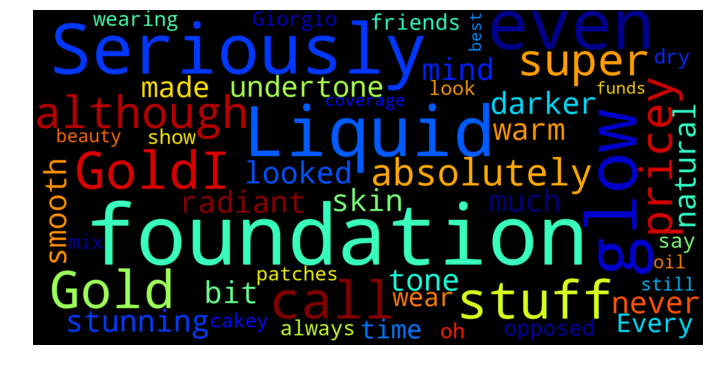

In [126]:
wd_list = []
for review in dark_tones:
    wd_list = sent_tokenize(review)
    
word_cloud(wd_list)

# TOPIC MODELING 

In [8]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [10]:
doc_sample = dark_tones[18]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Nothing', 'Compares!This', 'foundation', 'is', 'the', 'business.', 'Pure', 'and', 'simple.', 'I', 'really', 'wanted', 'to', 'hate', 'it', 'because', 'there', 'is', 'so', 'much', 'hype', 'about', 'it', 'and', 'it', 'is', 'pricey.', 'But', 'I', 'love', 'it', 'so!', 'I', 'am', 'on', 'my', 'second', 'bottle', '(in', '9', 'months,', "didn't", 'wear', 'it', 'in', 'the', 'summer)\n\nI', 'was', 'looking', 'for', 'a', 'foundation', 'to', 'wear', 'on', 'my', 'wedding', 'day', 'and', 'had', 'tried', 'about', 'a', 'dozen', 'foundations', 'over', 'the', 'span', 'of', 'weeks.', 'When', 'the', 'Sephora', 'MUA', 'put', 'this', 'on', 'me', 'it', 'was', 'instant', 'love.', 'My', 'skin', 'became', 'instantly', 'evened', 'out,', 'glowing,', 'but', 'very', 'natural.\n\nNo', 'two', 'ways', 'about', 'it,', 'like', 'the', 'description', 'says,', 'this', 'is', 'a', 'lightweight', 'and', 'radiant', 'finish', 'foundation.', 'IT', 'IS', 'DEWY!', 'so', 'you', 'have', 'to', 'be', 'into', 'that

In [9]:
documents

,text,index
0,It really is all that!!!I'd been on the fence ...,0
1,"great foundationBest foundation ever, lightwei...",1
2,My favourite foundation.I have extremely dry s...,2
3,YASSSI have dry skin and this foundation gives...,3
4,One of the bestI am IN LOVE with this foundati...,4
5,A-M-A-Z-I-N-GI love the finish of this foundat...,5
6,"""Your skin has gotten so much better!""Let me s...",6
7,HOLY. GRAIL.I've sampled almost every foundati...,7
8,great for dry skinIf you are light/medium skin...,8
9,Amazing!I was a makeup artist for 10 years and...,9


In [22]:
nlp = spacy.load('en_core_web_lg')

OSError: [E050] Can't find model 'en_core_web_lg'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [ ]:
doc = nlp(wines["description"][3])
spacy.displacy.render(doc, style='ent',jupyter=True)

In [ ]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
#lemmatization
review = str(" ".join([i.lemma_ for i in doc]))
doc = nlp(review)
spacy.displacy.render(doc, style='ent',jupyter=True)
for i in nlp(review):
    print(i,"=>",i.pos_)

In [ ]:
# Parser for reviews
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

wines["processed_description"] = wines["description"].progress_apply(spacy_tokenizer)

In [ ]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(wines["processed_description"])

In [ ]:
NUM_TOPICS = 10
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized) 

# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [ ]:
print("LDA Model:")
selected_topics(lda, vectorizer)

In [ ]:
print("NMF Model:")
selected_topics(nmf, vectorizer)

In [ ]:
print("LSI Model:")
selected_topics(lsi, vectorizer)

In [ ]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash